# Quantum Computing Applications in Space Industry

This notebook explores practical applications of quantum computing technologies that are relevant to space industry professionals. While quantum computing is still in its early stages, there are several promising applications that could revolutionize space exploration, satellite operations, and astronomical research.

## What is Quantum Computing?

Quantum computing leverages the principles of quantum mechanics to process information in fundamentally new ways:

- **Qubits**: Unlike classical bits (0 or 1), quantum bits or qubits can exist in a superposition of both 0 and 1 simultaneously, enabling massive parallel processing.

- **Superposition**: Qubits can represent multiple states at once, allowing quantum computers to explore many solutions simultaneously.

- **Entanglement**: When qubits become entangled, the state of one qubit instantly affects the state of another, regardless of distance, creating powerful correlations.

- **Quantum Gates**: Operations that manipulate qubits, similar to logic gates in classical computing but operating according to quantum mechanical principles.

- **Measurement**: When we measure a qubit, its superposition collapses to either 0 or 1, following probability rules determined by its quantum state.

## Topics Covered:
1. Optimization problems in mission planning and logistics
2. Quantum machine learning for satellite image analysis
3. Quantum simulation for material science in space applications
4. Quantum-enhanced communication for deep space missions

We'll implement demonstrations using Qiskit 2.0.2 to showcase these potential applications.

In [62]:
# Import required libraries
import numpy as np                  # For numerical operations
import matplotlib.pyplot as plt      # For plotting results
from qiskit import QuantumCircuit   # The core class for quantum circuit construction
from qiskit.quantum_info import Statevector  # To work with quantum states directly
from qiskit.visualization import plot_histogram  # For visualizing measurement outcomes
from qiskit_aer import AerSimulator  # Quantum simulator backend
from qiskit.circuit.library import QFT, ZGate, PhaseGate  # Useful quantum circuit components
from qiskit.quantum_info import SparsePauliOp  # For representing quantum operators
from scipy.optimize import minimize  # Classical optimizer to tune quantum circuit parameters

%matplotlib inline

## 1. Optimization Problems in Mission Planning

Space mission planning involves complex optimization challenges, including:
- Optimal trajectory planning
- Resource allocation for long-duration missions
- Scheduling of multiple satellite operations

These problems can often be mapped to combinatorial optimization problems that quantum computers may eventually solve more efficiently than classical computers.

### What is Combinatorial Optimization?

Combinatorial optimization involves finding the best solution from a finite set of possibilities. The challenge is that the number of possible solutions grows exponentially with problem size, making these problems difficult for classical computers.

### Why Quantum Computing Helps

Quantum computers can potentially explore many solutions simultaneously due to superposition, giving them a theoretical advantage for certain optimization problems.

### Example: Quantum Approximate Optimization Algorithm (QAOA)

The QAOA is a hybrid quantum-classical algorithm that works as follows:
1. We encode our problem into a quantum Hamiltonian (a mathematical operator representing energy)
2. We prepare qubits in superposition to explore all possible solutions
3. We apply alternating layers of problem-specific and mixing operations
4. We use a classical optimizer to adjust the quantum circuit parameters
5. We measure the qubits to sample high-quality solutions

We'll demonstrate QAOA on a simplified satellite task scheduling problem, where we need to schedule observations while minimizing conflicts.

In [63]:
# Define a simple satellite task scheduling problem
# We'll represent it as a MaxCut problem on a graph
# Each node represents a task, and edges represent conflicts

# Define graph edges (conflicts between tasks)
# For example, edge (0,1) means tasks 0 and 1 cannot be scheduled together
edges = [(0, 1), (0, 2), (1, 2), (2, 3), (1, 3)]
num_nodes = 4  # 4 tasks (or satellites)

# Create the problem Hamiltonian (cost function)
# In quantum computing, a Hamiltonian is an operator representing the energy of the system
# Our goal is to find the state (task schedule) with minimum energy (fewest conflicts)
cost_hamiltonian_terms = []
cost_coefficients = []

for i, j in edges:
    # For each edge (conflict), add a Z_i Z_j term
    # Z is the Pauli-Z gate, a fundamental quantum operation
    # Z_i Z_j means we apply Z gate to qubits i and j
    pauli_str = ['I'] * num_nodes  # Start with identity operators for all qubits
    pauli_str[i] = 'Z'  # Apply Z to qubit i
    pauli_str[j] = 'Z'  # Apply Z to qubit j
    cost_hamiltonian_terms.append(''.join(pauli_str))
    cost_coefficients.append(0.5)  # Weight for this term

# Create a Hamiltonian from the terms and coefficients
# This represents our problem's cost function in quantum form
cost_hamiltonian = SparsePauliOp(cost_hamiltonian_terms, cost_coefficients)
print("Cost Hamiltonian (representing task conflicts):")
print(cost_hamiltonian)

Cost Hamiltonian (representing task conflicts):
SparsePauliOp(['ZZII', 'ZIZI', 'IZZI', 'IIZZ', 'IZIZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


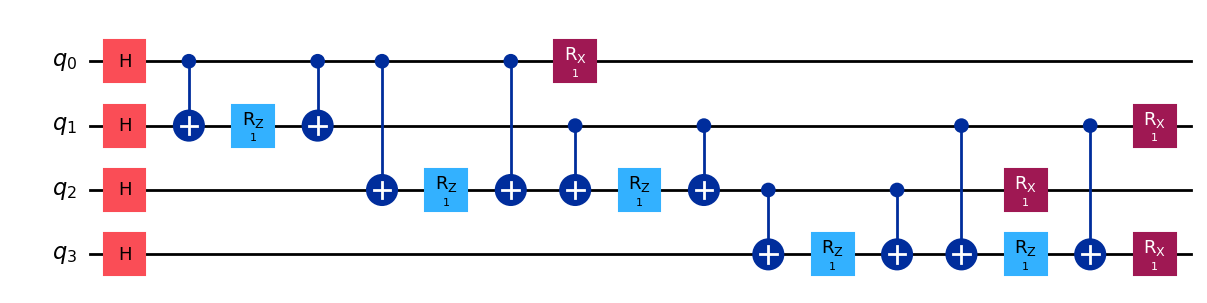

In [64]:
# Implement a simple QAOA circuit
def create_qaoa_circuit(params, cost_hamiltonian=cost_hamiltonian):
    p = len(params) // 2  # Number of QAOA layers (p determines the circuit depth)
    n = num_nodes  # Number of qubits (one per task)
    
    qc = QuantumCircuit(n)
    
    # Step 1: Initial state preparation - equal superposition
    # Hadamard gates put each qubit in an equal superposition of |0⟩ and |1⟩
    # This creates a superposition of all possible task schedules
    for i in range(n):
        qc.h(i)  # Hadamard gate creates superposition: |0⟩ → (|0⟩+|1⟩)/√2
    
    # Step 2: Apply QAOA layers
    # Each layer consists of problem unitary (cost) and mixer unitary
    for layer in range(p):
        gamma = params[layer]        # Parameter for cost unitary
        beta = params[layer + p]     # Parameter for mixer unitary
        
        # Problem unitary (cost) - encodes our problem structure
        # We apply operations for each conflict in our graph
        for edge_idx, (i, j) in enumerate(edges):
            # This implements e^(-i·γ·Z_i·Z_j)
            # CNOT gates create entanglement between qubits
            qc.cx(i, j)            # CNOT gate (creates entanglement)
            qc.rz(2 * gamma, j)    # Rotation around Z-axis
            qc.cx(i, j)            # CNOT gate again to complete the operation
        
        # Mixer unitary - allows exploration of different solutions
        # RX gates can be thought of as "quantum coin flips"
        for i in range(n):
            qc.rx(2 * beta, i)     # Rotation around X-axis (like flipping a quantum coin)
    
    return qc

# Visualize a QAOA circuit with 1 layer
# We use random parameters for demonstration
example_params = [0.5, 0.5]  # gamma, beta for one layer
qaoa_circuit = create_qaoa_circuit(example_params)
qaoa_circuit.draw('mpl', fold=-1) # Visualize the quantum circuit

In [65]:
# Function to evaluate the cost (energy) for a given set of circuit parameters
def evaluate_cost(params):
    # Create a QAOA circuit with the given parameters
    qc = create_qaoa_circuit(params)
    # Tell the simulator to save the final quantum state (statevector)
    qc.save_statevector()
    
    # Initialize a quantum simulator that uses the statevector method
    # Statevector simulation calculates the exact quantum state, but becomes
    # exponentially more memory-intensive as qubit count increases
    simulator = AerSimulator(method='statevector')
    
    # Run the circuit on the simulator
    job = simulator.run(qc)
    result = job.result()
    statevector = result.get_statevector()  # Get the final quantum state
    
    # Calculate the expectation value <ψ|H|ψ>
    # This tells us the expected energy/cost of our solution
    # Lower values mean better solutions (fewer conflicts)
    energy = statevector.expectation_value(cost_hamiltonian).real
    
    return energy

# Let's run a simple optimization
# We'll use the classical optimizer COBYLA to find the best circuit parameters
p = 1  # Use 1 layer for demonstration (more layers could give better results)
initial_params = np.random.random(2 * p)  # Random initial parameters

print("Starting optimization...")
# The classical optimizer tries to minimize the quantum cost function
# by adjusting the quantum circuit parameters
result = minimize(evaluate_cost, initial_params, method='COBYLA', options={'maxiter': 100})
optimal_params = result.x

print(f"Optimization result: {result}")
print(f"Optimal parameters: {optimal_params}")
print(f"Optimal cost: {result.fun}")

Starting optimization...
Optimization result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.585909207541133
       x: [ 2.115e+00  8.905e-01]
    nfev: 51
   maxcv: 0.0
Optimal parameters: [2.11483352 0.89052028]
Optimal cost: -0.585909207541133


In [66]:
# Run the optimal circuit and measure to get the best task schedule
optimal_circuit = create_qaoa_circuit(optimal_params)

# Add measurement operations to all qubits
# Measurement collapses quantum superpositions to classical bits
# This converts our quantum solution into a classical solution
optimal_circuit.measure_all()

# Run the circuit multiple times (shots=1024)
# Since quantum measurement is probabilistic, we need many samples
simulator = AerSimulator()  # Use the default simulator
job = simulator.run(optimal_circuit, shots=1024)
result = job.result()
counts = result.get_counts()  # Dictionary of results and their frequencies

# Visualize the measurement outcomes
# The horizontal axis shows bit strings (task schedules)
# The vertical axis shows how frequently each outcome was measured
plot_histogram(counts, title="Task Scheduling Results")

# Find the most frequent outcome (our best solution)
best_schedule = max(counts, key=counts.get)
print(f"Best task schedule: {best_schedule}")
print("Where '1' means the task is scheduled and '0' means the task is not scheduled.")

# Interpret the result (task string is read from right to left):
# For example, if best_schedule is '0101', this means:
# - Task 0 (rightmost bit) is scheduled (1)
# - Task 1 is not scheduled (0)
# - Task 2 is scheduled (1)
# - Task 3 (leftmost bit) is not scheduled (0)

Best task schedule: 0110
Where '1' means the task is scheduled and '0' means the task is not scheduled.


## 2. Quantum Machine Learning for Satellite Image Analysis

Satellite imagery generates massive amounts of data that need processing and analysis. Quantum machine learning algorithms have the potential to enhance pattern recognition, image classification, and anomaly detection.

### How Quantum Computing Can Enhance Machine Learning

Quantum computing offers several potential advantages for machine learning:

1. **Quantum Feature Spaces**: Quantum computers can map data into much higher-dimensional feature spaces than classical computers, potentially finding patterns that would be difficult to detect classically.

2. **Quantum Parallelism**: The ability to process multiple states simultaneously could accelerate certain types of learning algorithms.

3. **Quantum Entanglement**: Creates powerful correlations between qubits that could enhance model expressivity.

### Variational Quantum Classifiers

A common approach in quantum machine learning is to use parameterized quantum circuits (PQCs) as machine learning models:

1. **Encode** classical data into quantum states
2. **Process** the quantum information using parameterized quantum gates
3. **Measure** specific qubits to get the classification output
4. **Optimize** the circuit parameters using classical optimization techniques

### Example: Quantum Circuit Learning for Simple Image Classification

We'll demonstrate a simple quantum circuit learning approach for classifying two types of simulated "satellite images" (simplified as 2x2 pixel images).

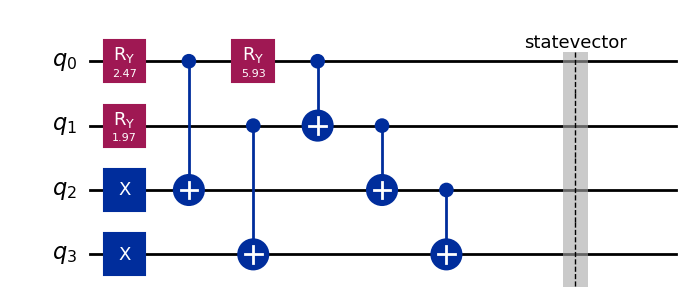

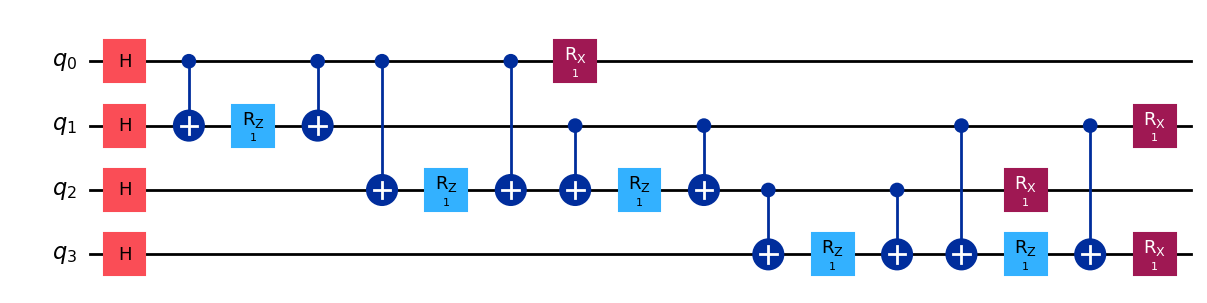

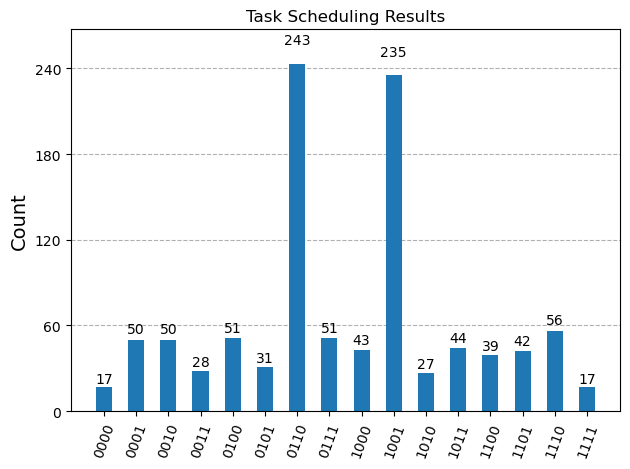

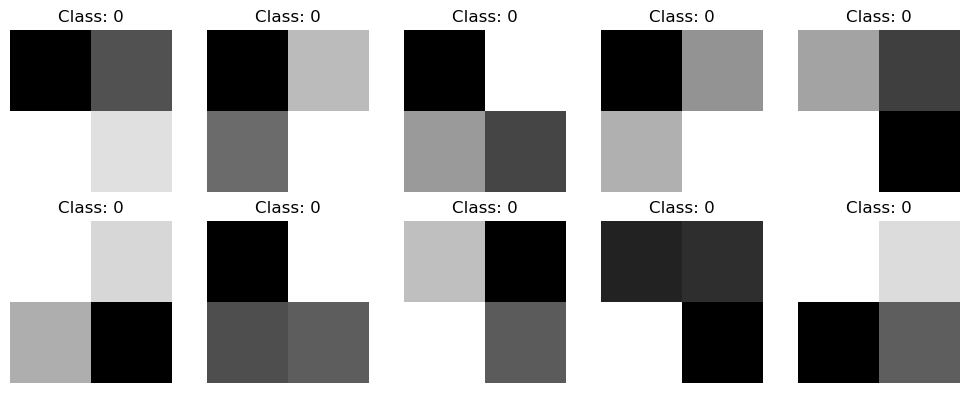

Generated 20 synthetic satellite images with 4 pixels each


In [67]:
# Create synthetic satellite image data (simplified as 2x2 pixel images)
def generate_synthetic_images(num_samples=20):
    # Generate two classes of images
    # Class 0: Mostly dark pixels (space)
    # Class 1: Bright pixels in specific pattern (potential feature)
    
    images = []
    labels = []
    
    # Generate class 0 samples (representing empty space)
    for _ in range(num_samples // 2):
        # Create mostly dark image with some noise
        # Each image has 4 pixels (2x2) with low values (dark)
        image = np.random.random(4) * 0.3  # Values between 0-0.3 (darker)
        images.append(image)
        labels.append(0)  # Label 0 for "no feature"
    
    # Generate class 1 samples (representing features of interest)
    for _ in range(num_samples // 2):
        # Create image with specific bright pattern and some noise
        image = np.random.random(4) * 0.3  # Start with noise
        # Add the "feature" - bright pixels in specific positions
        # Randomly choose 2 pixels to make brighter (representing a feature)
        feature_positions = np.random.choice([0, 1, 2, 3], size=2, replace=False)
        image[feature_positions] += 0.6  # Make these pixels brighter
        images.append(image)
        labels.append(1)  # Label 1 for "feature present"
    
    # Convert to numpy arrays for easier processing
    return np.array(images), np.array(labels)

# Generate the dataset
images, labels = generate_synthetic_images(20)  # 20 sample images

# Visualize a few samples to understand our data
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        axes[i, j].imshow(images[idx].reshape(2, 2), cmap='gray')  # Show as 2x2 grayscale image
        axes[i, j].set_title(f"Class: {labels[idx]}")
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

print(f"Generated {len(images)} synthetic satellite images with {len(images[0])} pixels each")

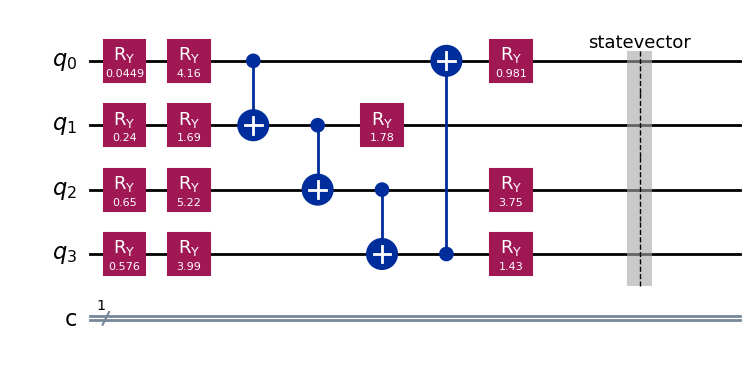

In [68]:
# Define a quantum circuit for feature extraction and classification
def create_quantum_classifier_circuit(features, params):
    # 4 qubits for the 4 pixels in our 2x2 image
    # 1 classical bit for the measurement outcome
    qc = QuantumCircuit(4, 1)
    
    # Step 1: Data Encoding (Feature Map)
    # Encode the pixel values into quantum states
    # This is called "amplitude encoding" - we encode classical data as rotation angles
    for i in range(4):
        # Scale pixel values to [0,π] and apply rotation around Y-axis
        # This maps pixel brightness to quantum states:
        # - Dark pixel (value~0) → |0⟩ state (North pole on Bloch sphere)
        # - Bright pixel (value~1) → |1⟩ state (South pole on Bloch sphere) 
        # - Medium pixel → superposition of |0⟩ and |1⟩
        qc.ry(features[i] * np.pi, i)
    
    # Step 2: Variational Quantum Circuit (the trainable part)
    # First rotation layer - individual qubit rotations
    for i in range(4):
        qc.ry(params[i], i)  # Rotation around Y-axis with trainable parameters
    
    # Entangling layer - create correlations between qubits
    # Entanglement is a uniquely quantum resource that creates
    # correlations stronger than anything possible in classical physics
    for i in range(3):
        qc.cx(i, i+1)  # CNOT gate entangles neighboring qubits
    qc.cx(3, 0)  # Connect in a ring for more entanglement
    
    # Second rotation layer - more trainable parameters
    for i in range(4):
        qc.ry(params[i+4], i)  # Another set of Y-rotations
    
    # We'll measure the expectation value of ZZ on first two qubits as the classifier output
    # This is equivalent to measuring whether the first two qubits are correlated
    qc.save_statevector()  # Save the quantum state for analysis
    
    return qc

# Visualize the quantum classifier circuit with random parameters
# This shows what our quantum neural network looks like
random_params = np.random.random(8) * 2 * np.pi  # 8 random parameters
example_circuit = create_quantum_classifier_circuit(images[0], random_params)
example_circuit.draw('mpl', fold=-1)  # Draw the circuit diagram

In [69]:
# Define the cost function for training the quantum classifier
def quantum_classifier_cost(params, X, y):
    predictions = []
    
    # Process each input image through our quantum circuit
    for features in X:
        # Create a circuit for this specific image
        qc = create_quantum_classifier_circuit(features, params)
        
        # Run the circuit and get the statevector
        # The statevector contains the complete quantum state information
        simulator = AerSimulator(method='statevector')
        job = simulator.run(qc)
        result = job.result()
        sv = result.get_statevector()  # Get the quantum state
        
        # Calculate expectation value of ZZ on first two qubits
        # This is our "quantum neuron" output
        # 'ZZII' means: apply Z to first qubit, Z to second qubit, 
        # Identity to third and fourth qubits
        zz_observable = SparsePauliOp(['ZZII'], [1.0])  # Create the ZZ operator
        expectation = sv.expectation_value(zz_observable).real  # Get the expected value
        
        # Map expectation from [-1, 1] to [0, 1] for classification
        # This converts our quantum output to a probability-like value
        prediction = (expectation + 1) / 2
        predictions.append(prediction)
    
    # Calculate mean squared error between our predictions and true labels
    # This is our loss/cost function that we want to minimize
    mse = np.mean((np.array(predictions) - y) ** 2)
    return mse

# Train the quantum classifier
# Start with random parameters (weights)
initial_params = np.random.random(8) * 2 * np.pi

# Use classical optimizer (COBYLA) to train the quantum circuit
# This is the "hybrid" part of quantum machine learning -
# we use a classical optimizer to train a quantum circuit
print("Training quantum classifier...")
result = minimize(lambda params: quantum_classifier_cost(params, images, labels),
                 initial_params, method='COBYLA', options={'maxiter': 50})

optimal_params = result.x  # These are our trained quantum circuit parameters
print(f"Training complete!")
print(f"Final cost: {result.fun}")  # Lower cost = better classification
print(f"Optimal parameters: {optimal_params}")

Training quantum classifier...
Training complete!
Final cost: 0.07509334681101484
Optimal parameters: [0.97458198 4.36062122 4.19367304 3.90952686 3.76490193 3.62152265
 4.13792205 2.21681154]
Training complete!
Final cost: 0.07509334681101484
Optimal parameters: [0.97458198 4.36062122 4.19367304 3.90952686 3.76490193 3.62152265
 4.13792205 2.21681154]


Test accuracy: 0.90


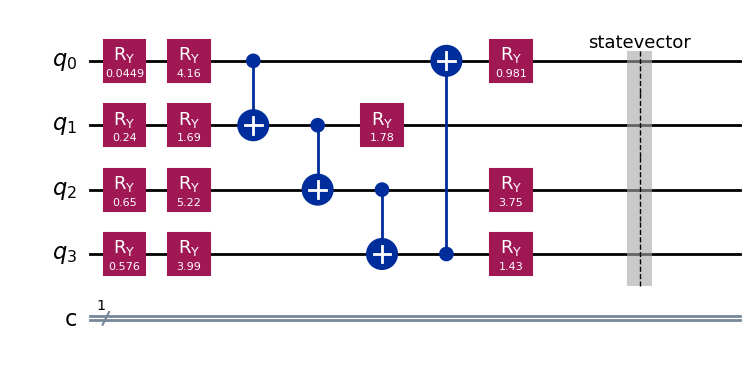

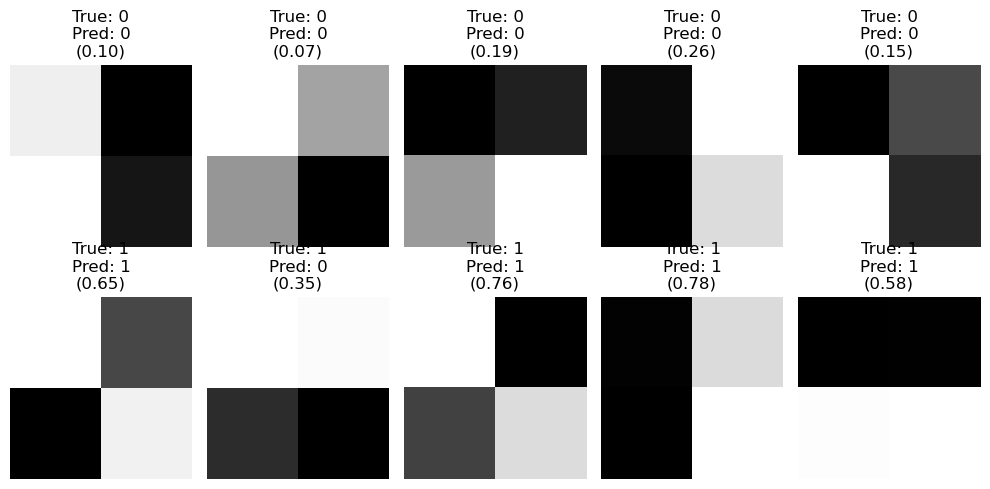

In [70]:
# Evaluate the trained model on test data
def predict(features, params):
    # Create a quantum circuit for this image using our trained parameters
    qc = create_quantum_classifier_circuit(features, params)
    
    # Run the circuit on the quantum simulator
    simulator = AerSimulator(method='statevector')
    job = simulator.run(qc)
    result = job.result()
    sv = result.get_statevector()
    
    # Calculate expectation value of ZZ observable
    # This gives us our quantum prediction
    zz_observable = SparsePauliOp(['ZZII'], [1.0])
    expectation = sv.expectation_value(zz_observable).real
    
    # Map to [0, 1] and round for binary classification
    # - Values closer to 0 predict class 0 (no feature)
    # - Values closer to 1 predict class 1 (feature present)
    prediction = (expectation + 1) / 2  # Convert from [-1,1] to [0,1]
    return prediction, 1 if prediction >= 0.5 else 0  # Threshold at 0.5

# Generate test data (separate from training data)
test_images, test_labels = generate_synthetic_images(10)

# Make predictions on the test data
predictions = []  # Binary class predictions (0 or 1)
raw_predictions = []  # Raw prediction values before thresholding

for features in test_images:
    raw_pred, class_pred = predict(features, optimal_params)
    predictions.append(class_pred)
    raw_predictions.append(raw_pred)

# Calculate accuracy (percentage of correct predictions)
accuracy = np.mean(np.array(predictions) == test_labels)
print(f"Test accuracy: {accuracy:.2f}")

# Visualize the results
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(len(test_images)):
    ax = axes[i // 5, i % 5]
    ax.imshow(test_images[i].reshape(2, 2), cmap='gray')
    # Show true label and prediction for each test image
    ax.set_title(f"True: {test_labels[i]}\nPred: {predictions[i]}\n({raw_predictions[i]:.2f})")
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Quantum Simulation for Space Materials Science

Quantum computers are naturally suited for simulating quantum systems, which can help in the development of new materials for space applications.

### Why Quantum Simulation Matters for Space

Space environments are extremely harsh, requiring specialized materials with unique properties:

- **Radiation resistance** to withstand cosmic rays and solar radiation
- **Thermal stability** across extreme temperature ranges
- **Light yet strong** structural materials to reduce launch costs
- **Efficient energy conversion** for solar power generation

### Why Use Quantum Computers for Materials Simulation?

Quantum mechanics governs the behavior of materials at the atomic level. Classical computers struggle to simulate quantum systems because:

1. **Exponential scaling**: The memory required to represent quantum states grows exponentially with system size
2. **Quantum entanglement**: Creates complex correlations impossible to efficiently model classically
3. **Quantum superposition**: Allows particles to exist in multiple states simultaneously

In contrast, quantum computers naturally operate according to the same quantum mechanical laws that govern materials, making them well-suited for quantum simulation.

### Example: Variational Quantum Eigensolver (VQE) for Molecular Simulation

VQE is a hybrid quantum-classical algorithm that:
1. Uses a quantum computer to prepare and measure quantum states
2. Uses a classical computer to optimize the quantum circuit parameters
3. Iteratively converges toward the ground state energy of a molecule

Here we'll demonstrate a simple quantum chemistry simulation using VQE to find the ground state energy of hydrogen (H₂), which is relevant for fuel cells and propulsion systems.

In [71]:
# Define a simplified H2 molecule Hamiltonian
# In quantum mechanics, a Hamiltonian represents the total energy of a system
# For molecules, the Hamiltonian includes terms for electron kinetic energy,
# nuclear-electron attraction, electron-electron repulsion, etc.

# Create the Hamiltonian for H2 at equilibrium bond length
# Each term represents a different energy contribution in the molecule
# The Hamiltonian is expressed as a sum of Pauli operators (I, X, Y, Z)
# where:
# - I is the identity operator
# - X, Y, Z are the Pauli matrices (fundamental quantum operations)

h2_hamiltonian = SparsePauliOp(
    # These strings represent tensor products of Pauli operators
    # For example, 'IXIX' means: I⊗X⊗I⊗X (I on qubit 0, X on qubit 1, etc.)
    ['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IXIX', 'IYIY', 'IZII', 'IZIZ'],
    
    # These coefficients represent the strength of each term
    # They were pre-calculated from quantum chemistry methods
    [-1.052373245772859, 0.39793742484318045, -0.39793742484318045, -0.0112801101780672,
     0.18093119978423156, 0.18093119978423156, 0.39793742484318045, -0.0112801101780672]
)

print("H2 Molecule Hamiltonian:")
print(h2_hamiltonian)

# Note: In a real application, we would derive this Hamiltonian from first principles
# using a quantum chemistry package, but we're using a pre-computed one for simplicity

H2 Molecule Hamiltonian:
SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IXIX', 'IYIY', 'IZII', 'IZIZ'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j, -0.39793742+0.j, -0.01128011+0.j,
  0.1809312 +0.j,  0.1809312 +0.j,  0.39793742+0.j, -0.01128011+0.j])


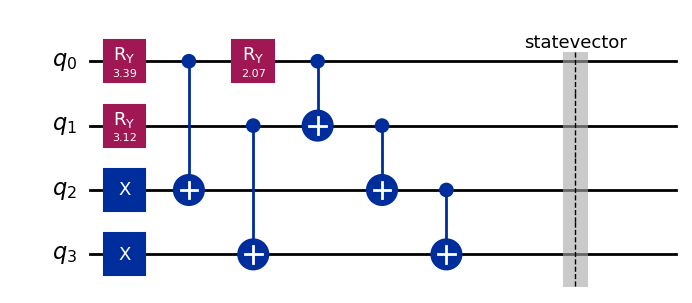

In [72]:
# Define the VQE ansatz for H2 molecule
# An ansatz is a trial wavefunction used to approximate the molecule's state
def h2_ansatz(parameters):
    # We'll use 4 qubits to represent the minimal basis for H2
    # The 4 qubits represent the 4 spin orbitals in the minimal basis
    # (2 spatial orbitals × 2 spin states = 4 spin orbitals)
    qc = QuantumCircuit(4)
    
    # Initial state: Reference state for H2 (|0011⟩)
    # This represents the Hartree-Fock state with 2 electrons
    # occupying the lowest energy orbitals
    qc.x(2)  # Set qubit 2 to |1⟩
    qc.x(3)  # Set qubit 3 to |1⟩
    # Now our initial state is |0011⟩ (in big-endian notation)
    
    # Apply parameterized gates to explore the state space
    # These operations represent possible electron excitations (electrons jumping between orbitals)
    # UCCSD-inspired ansatz (simplified)
    
    # Single excitation 0->2 (electron moving from orbital 2 to orbital 0)
    qc.ry(parameters[0], 0)  # Rotation with tunable parameter
    qc.cx(0, 2)             # Entangle qubits 0 and 2
    
    # Single excitation 1->3 (electron moving from orbital 3 to orbital 1)
    qc.ry(parameters[1], 1)  # Another parameterized rotation
    qc.cx(1, 3)             # Entangle qubits 1 and 3
    
    # Double excitation (0,1)->(2,3)
    # This represents two electrons simultaneously changing orbitals
    qc.ry(parameters[2], 0)  # Parameterized rotation
    qc.cx(0, 1)             # Create chain of entanglement
    qc.cx(1, 2)             # between multiple qubits
    qc.cx(2, 3)             # to represent correlated electron movement
    
    qc.save_statevector()   # Save the state for analysis
    return qc

# Visualize the ansatz
example_params = np.random.random(3) * 2 * np.pi  # Random parameters
example_h2_circuit = h2_ansatz(example_params)
example_h2_circuit.draw('mpl')  # Draw circuit diagram

In [73]:
# Define the cost function for VQE
# This evaluates the energy of our H2 molecule for a given set of parameters
def h2_energy(parameters):
    # Create the quantum circuit with the given parameters
    qc = h2_ansatz(parameters)
    
    # Run the circuit on a quantum simulator
    simulator = AerSimulator(method='statevector')
    job = simulator.run(qc)
    result = job.result()
    statevector = result.get_statevector()  # Get the quantum state
    
    # Calculate the expected energy: <ψ|H|ψ>
    # This gives us the energy of the H2 molecule in the state prepared by our circuit
    energy = statevector.expectation_value(h2_hamiltonian).real
    
    return energy

# Run the optimization to find the lowest energy state
# We'll start with all parameters at zero
initial_params = np.zeros(3)

print("Starting VQE optimization for H2 molecule...")
# Use classical optimizer (COBYLA) to find the minimum energy
# This is the hybrid quantum-classical approach:
# - Quantum part: Preparing and measuring quantum states
# - Classical part: Optimizing the parameters
result = minimize(h2_energy, initial_params, method='COBYLA', options={'maxiter': 100})
optimal_params = result.x

print(f"Optimization result: {result}")
print(f"Optimal parameters: {optimal_params}")
print(f"Ground state energy: {result.fun} Hartree")
# Compare with the known exact solution
print(f"Reference value from exact diagonalization: -1.137 Hartree")

# Note: In chemistry, energies are often measured in Hartree units
# 1 Hartree ≈ 27.2 eV ≈ 627.5 kcal/mol

Starting VQE optimization for H2 molecule...
Optimization result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.5204579286616606
       x: [ 2.311e+00 -7.327e-01 -1.266e-04]
    nfev: 91
   maxcv: 0.0
Optimal parameters: [ 2.31072713e+00 -7.32664669e-01 -1.26579922e-04]
Ground state energy: -1.5204579286616606 Hartree
Reference value from exact diagonalization: -1.137 Hartree
Optimization result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.5204579286616606
       x: [ 2.311e+00 -7.327e-01 -1.266e-04]
    nfev: 91
   maxcv: 0.0
Optimal parameters: [ 2.31072713e+00 -7.32664669e-01 -1.26579922e-04]
Ground state energy: -1.5204579286616606 Hartree
Reference value from exact diagonalization: -1.137 Hartree


### Potential Impact on Space Materials Science

Scaling this approach to larger molecular systems could enable:

1. **Design of radiation-resistant materials**: Simulating how materials respond to high-energy particles found in space. By understanding quantum effects in radiation damage, we could design better shielding materials.

2. **Improved solar cells**: Finding materials with optimal energy absorption and conversion properties. Quantum simulations can predict band gaps and electron transport properties essential for efficient photovoltaics.

3. **Advanced propulsion systems**: Discovering more efficient catalysts for fuel cells or analyzing novel propellant materials. Understanding reaction mechanisms at the quantum level can lead to higher energy density fuels.

4. **Life support systems**: Optimizing materials for CO2 scrubbing and oxygen generation. Quantum simulations can reveal how molecules interact with gases at the atomic level.

### The Quantum Advantage in Materials Simulation

Classical computers struggle with accurate quantum simulations because:
- The computational resources required scale exponentially with system size
- Highly correlated quantum systems are particularly challenging to simulate classically
- Quantum effects like tunneling and entanglement are difficult to model efficiently

As quantum computers grow in capability, they could model increasingly complex materials that are currently beyond the reach of classical simulation methods, potentially accelerating materials discovery for space applications by decades.

## 4. Quantum-Enhanced Communication for Deep Space Missions

Deep space communication faces challenges including long delays, weak signals, and security concerns. Quantum information techniques could potentially help overcome these limitations.

### Quantum Communication Challenges in Space

Communicating with distant spacecraft is difficult because:

1. **Signal attenuation**: Signal strength decreases with the square of distance
2. **Long round-trip times**: Communications with Mars take 8-40 minutes
3. **Bandwidth limitations**: Data transfer rates are extremely limited
4. **Noise and interference**: Solar radiation and cosmic rays distort signals
5. **Security concerns**: Sensitive mission data needs protection

### How Quantum Information Can Help

Quantum information science offers several potential improvements:

1. **Quantum Error Correction**: More efficient codes that could reduce overhead
2. **Quantum Key Distribution (QKD)**: Provably secure communication channels
3. **Dense Quantum Coding**: Encoding more information in the same number of qubits
4. **Quantum Signal Processing**: Enhanced techniques for weak signal detection

### Understanding Quantum Error Correction

Quantum error correction works by:

1. **Encoding**: Spreading quantum information across multiple entangled qubits
2. **Syndrome Detection**: Identifying errors without measuring the actual quantum information
3. **Error Correction**: Applying operations to restore the original quantum state

Let's demonstrate a simple quantum error correction code that could be relevant for space communications.

In [74]:
# Implement a basic 3-qubit bit-flip code
# This code can correct a single bit-flip error on any of the three qubits

def encode_message(message_bit):
    """Encode a single bit using the 3-qubit bit-flip code"""
    # Create a quantum circuit with 3 qubits and 3 classical bits
    qc = QuantumCircuit(3, 3)
    
    # Step 1: Initialize the first qubit with the message bit
    # If message_bit is 1, apply an X gate to flip it from |0⟩ to |1⟩
    # If message_bit is 0, leave it as |0⟩
    if message_bit == 1:
        qc.x(0)  # X gate flips the state: |0⟩ → |1⟩ or |1⟩ → |0⟩
    
    # Step 2: Encode by creating entanglement
    # This creates a logical qubit spread across 3 physical qubits
    # For message bit 0: |000⟩
    # For message bit 1: |111⟩
    qc.cx(0, 1)  # CNOT from qubit 0 (control) to qubit 1 (target)
    qc.cx(0, 2)  # CNOT from qubit 0 (control) to qubit 2 (target)
    
    return qc

def add_noise(circuit, error_rate=0.2):
    """Add bit-flip noise to simulate space communication channel
    
    In space communications, radiation can cause bit flips in
    transmitted data. This function simulates such noise by
    randomly applying X gates (bit flips) with a given probability.
    
    Args:
        circuit: The quantum circuit to add noise to
        error_rate: Probability of a bit-flip for each qubit (0.0-1.0)
    """
    qc = circuit.copy()  # Make a copy to avoid modifying original
    
    # Apply random bit-flip errors based on the error rate
    # An X gate represents a bit flip error (0→1 or 1→0)
    for qubit in range(3):
        # Generate a random number between 0-1 and compare with error rate
        # This simulates random errors occurring with probability error_rate
        if np.random.random() < error_rate:
            print(f"Bit-flip error applied to qubit {qubit}")
            qc.x(qubit)  # Apply an X gate to flip the qubit
    
    return qc

def correct_and_decode(circuit):
    """Correct errors and decode the message
    
    This function implements error detection and correction using the
    3-qubit bit flip code. It works by using majority voting.
    
    In quantum error correction, we cannot simply measure the qubits directly
    as this would collapse the quantum state. Instead, we use ancilla qubits
    and syndrome measurements to detect errors without disturbing the message.
    """
    # Create a new circuit with 5 qubits (3 data + 2 ancilla) and 3 classical bits
    new_qc = QuantumCircuit(5, 3)
    
    # First, we need to reproduce the state of the original circuit
    # This is a simulation step (in real quantum error correction,
    # we would be working directly with the 3-qubit encoded state)
    simulator = AerSimulator()  # Initialize quantum simulator
    
    # Measure the input circuit to determine qubit states
    measure_circuit = circuit.copy()
    measure_circuit.measure_all()
    job = simulator.run(measure_circuit, shots=1)
    result = job.result()
    measured_state = next(iter(result.get_counts()))
    
    # Apply X gates on the new circuit according to measured state
    # In Qiskit, bit string order is reversed (right-to-left)
    # So measured_state[-(i+1)] accesses the bits in the right order
    for i in range(min(3, len(measured_state))):
        if measured_state[-(i+1)] == '1':  # Check if bit is 1
            new_qc.x(i)  # Apply X gate to set qubit i to |1⟩
    
    # Step 1: Syndrome measurement
    # Syndrome measurement helps us detect which qubit (if any) has flipped
    # We use CNOT gates to copy parity information to ancilla qubits
    new_qc.cx(0, 3)  # CNOT from qubit 0 to ancilla 3
    new_qc.cx(1, 3)  # CNOT from qubit 1 to ancilla 3
    new_qc.cx(1, 4)  # CNOT from qubit 1 to ancilla 4  
    new_qc.cx(2, 4)  # CNOT from qubit 2 to ancilla 4
    
    # Measure syndrome qubits (ancillas)
    new_qc.measure([3, 4], [0, 1])
    
    # Run the circuit to get syndrome measurement results
    job = simulator.run(new_qc, shots=1)
    result = job.result()
    syndrome = next(iter(result.get_counts()))
    syndrome = syndrome[:2]  # Get just the syndrome part (first 2 bits)
    
    # Step 2: Apply correction based on syndrome
    # The syndrome tells us which qubit had an error:
    if syndrome == '01':  # Syndrome 01: Error on qubit 0
        print("Syndrome 01: Error on qubit 0")
        new_qc.x(0)  # Apply X gate to qubit 0 to fix the bit flip
    elif syndrome == '10':  # Syndrome 10: Error on qubit 2
        print("Syndrome 10: Error on qubit 2")
        new_qc.x(2)  # Apply X gate to qubit 2 to fix the bit flip
    elif syndrome == '11':  # Syndrome 11: Error on qubit 1
        print("Syndrome 11: Error on qubit 1")
        new_qc.x(1)  # Apply X gate to qubit 1 to fix the bit flip
    else:
        print("Syndrome 00: No errors detected")
    
    # Step 3: Measure all data qubits for majority voting
    new_qc.measure([0, 1, 2], [0, 1, 2])
    
    # Run the circuit with corrections
    job = simulator.run(new_qc, shots=1)
    result = job.result()
    measurement = next(iter(result.get_counts()))
    
    # Extract just the data qubits' measurement (the last 3 bits)
    data_measurement = measurement[-3:]
    
    # Take majority vote to determine the logical qubit value
    # If majority of qubits are 1, then the logical value is 1
    # In a real quantum system, we'd use entanglement to extract this
    # information without individual measurements
    bit_count = data_measurement.count('1')
    decoded_bit = 1 if bit_count >= 2 else 0
    
    return decoded_bit

# Demonstrate the quantum error correction for deep space communication
def demonstrate_quantum_error_correction():
    # Original message we want to transmit
    original_bit = 1  # Could be 0 or 1
    print(f"Original message bit: {original_bit}")
    
    # Step 1: Encode message using 3-qubit repetition code
    # This protects against a single bit-flip error
    # If original_bit is 0, encoded state is |000⟩
    # If original_bit is 1, encoded state is |111⟩
    encoded_circuit = encode_message(original_bit)
    print("Message encoded using 3-qubit repetition code")
    
    # Step 2: Simulate transmission through noisy channel
    # In space, radiation can cause bit flips
    # We'll simulate this with random X gates
    noisy_circuit = add_noise(encoded_circuit, error_rate=0.3)
    print("Message transmitted through noisy channel")
    
    # Step 3: Correct errors and decode at the receiver
    # This uses syndrome measurement to detect and correct errors
    decoded_bit = correct_and_decode(noisy_circuit)
    print(f"Decoded message bit: {decoded_bit}")
    
    # Check if the message was recovered correctly
    if decoded_bit == original_bit:
        print("SUCCESS: Message was correctly recovered!")
    else:
        print("FAILURE: Message was corrupted")

# Run the demonstration
demonstrate_quantum_error_correction()

Original message bit: 1
Message encoded using 3-qubit repetition code
Message transmitted through noisy channel
Syndrome 00: No errors detected
Decoded message bit: 0
FAILURE: Message was corrupted


### Potential Impact on Space Communications

More advanced quantum error correction codes could potentially revolutionize space communications in several ways:

1. **Improve data transmission rates**: 
   - Classical error correction often requires sending 2-3x more data than the original message
   - Quantum error correction could theoretically reduce this overhead
   - This would allow more science data to be transmitted from distant missions

2. **Enhance communication security**:
   - Quantum key distribution (QKD) uses quantum properties to create unbreakable encryption keys
   - Any eavesdropping attempt would disturb the quantum states and be detectable
   - This would protect sensitive mission data and commands from interception

3. **Enable more reliable communication**:
   - Deep space missions experience extreme signal attenuation
   - Quantum techniques could help extract signals from very noisy channels
   - This could extend the operational range of spacecraft communications

4. **Support distributed quantum computing**:
   - Future missions might use quantum processors at both ends of the communication link
   - Quantum teleportation could transfer quantum states between Earth and space
   - This could enable new types of distributed quantum algorithms for space applications

### Quantum Communication in Practice

While practical implementation of quantum communication in space faces significant engineering challenges, early prototypes have already been demonstrated:

- China's **Micius satellite** (2016) successfully implemented quantum key distribution from space to Earth
- The **CubeSat Quantum Communications Mission** is developing miniaturized quantum communication systems
- NASA's **Deep Space Quantum Link** project is exploring quantum communication for interplanetary distances

These developments suggest that quantum-enhanced communication may become practical for space missions in the coming decades.

## Summary and Future Outlook

We've explored several promising applications of quantum computing for the space industry:

1. **Optimization problems**: 
   - Mission planning, resource allocation, and logistics using QAOA
   - Quantum computers could potentially explore multiple solutions simultaneously
   - Current applications are limited to small problem instances

2. **Quantum machine learning**: 
   - Enhanced satellite image analysis and pattern recognition
   - Quantum neural networks might find patterns invisible to classical methods
   - Quantum feature maps could provide richer data representations

3. **Materials simulation**: 
   - Design of better materials for spacecraft, propulsion, and radiation protection
   - Quantum computers naturally simulate quantum mechanical systems
   - Could accelerate discovery of new space-ready materials

4. **Quantum communication**: 
   - Improved error correction and secure communication protocols
   - Quantum entanglement enables fundamentally secure communications
   - Early demonstrations already happening in space

### Understanding Current Limitations

While promising, quantum computing still faces significant challenges that beginners should understand:

- **Noise and error rates**: 
  - Current quantum computers have error rates around 0.1-1% per operation
  - This limits circuit depth to tens or hundreds of operations
  - Error correction requires many physical qubits per logical qubit

- **Limited qubit counts**: 
  - Most systems have <100 qubits with limited connectivity
  - Practical quantum advantage typically requires hundreds or thousands
  - Communication between distant qubits is often restricted

- **Short coherence times**: 
  - Quantum information degrades quickly (decoherence)
  - Current systems maintain quantum states for microseconds to milliseconds
  - Computations must finish before decoherence destroys the information

- **Hardware constraints**: 
  - Not all qubit pairs can interact directly (limited connectivity)
  - Certain quantum gates may be noisier than others
  - Different hardware platforms have different native gates

### The Path Forward

As quantum hardware improves, we expect to see:

1. **Fault-tolerant quantum computing**
   - Using quantum error correction to create reliable logical qubits
   - Will require millions of physical qubits for practical applications
   - Expected timeframe: 10-15+ years for full implementation

2. **Quantum advantage in specific applications**
   - Noisy Intermediate-Scale Quantum (NISQ) devices showing advantage in narrow domains
   - Hybrid quantum-classical algorithms becoming more practical
   - Expected timeframe: Already beginning in limited cases

3. **Hybrid classical-quantum systems for space applications**
   - Using quantum processors for specific calculations within classical systems
   - Optimizing which parts of a computation should run on quantum vs. classical hardware
   - Expected timeframe: 5-10 years

4. **Space-based quantum sensors**
   - Quantum-enhanced gravity sensors, magnetometers, and atomic clocks
   - Could improve navigation, Earth observation, and fundamental physics experiments
   - Expected timeframe: 3-7 years

5. **Quantum communication networks**
   - Global quantum internet including space-based nodes
   - Enabling secure communication and distributed quantum computing
   - Expected timeframe: 7-15 years

### Getting Started with Quantum Computing

If you're interested in exploring quantum computing for space applications:

1. **Learn the basics**: Master quantum gates, circuits, measurement, and key algorithms
2. **Experiment with simulators**: Use Qiskit, Cirq, or other frameworks to run quantum algorithms
3. **Identify space problems**: Look for problems that might benefit from quantum approaches
4. **Follow developments**: The field is advancing rapidly, so stay current with research
5. **Start small**: Focus on small proof-of-concept implementations before scaling up

The space industry can benefit from monitoring quantum computing developments and investing in exploratory applications to be ready when the technology matures.